<a href="https://colab.research.google.com/github/tejaswaroop2310/nyc-taxi-trip-duration-prediction/blob/main/nyc_taxi_trip_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>


## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
#mounting the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id=library></a>
## Import libraries

In [ ]:
 pip install haversine


In [ ]:
#importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

<a id=data></a>
## Import Dataset

In [ ]:
#import the data from a csv file.
data = pd.read_csv('/content/drive/MyDrive/NYC Taxi Data.csv')

<a id=explore></a>
## Data Exploration


In [ ]:
#retriving the first five records of the data
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
#check the statistical summary of Data
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
#check the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


They are no missing values in the data set

In [ ]:
#Check shape of dataset
data.shape 

(1458644, 11)



There are approximately **14 lakhs of  records** in our dataset.

In [ ]:
#Check count of unique id's in the dataset
print(data.id.nunique())

1458644



There are no duplicate recors in the data set

In [ ]:
#Check for missing values
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no missing Values in the dataset

In [ ]:
#Converting timestamp to datetime format 
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [ ]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.day_name()
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [ ]:
#calculate_distance is a function used  to calculate distance between pickup and dropoff positions using Haversine formula.
def calculate_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calculate_distance(x), axis = 1)

In [ ]:

#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

In [ ]:
#Dummify all the categorical features 

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,3,0,17,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,6,0,1.805510,9.803672,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,1,11,6.385107,10.822216,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,4,2,19,1.485500,12.465738,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,3,5,13,1.188590,9.836608,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
#check the value count of the passengers
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

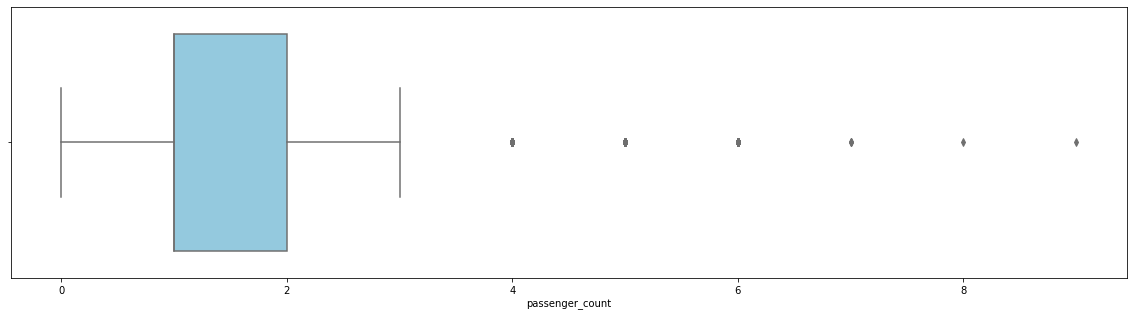

In [ ]:
#Plot the boxplot for the passengers count
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count, color='skyblue')
plt.show()


- There are  trips with 0 passenger count. 
- some trips consisted of even 7, 8 or 9 passengers which can be considered as outliers
- Most of trip consist of passenger either 1 or 2.



In [ ]:
#Check the Statistical summary of the passenger count
data.passenger_count.describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

As we can see. Mean median and mode are all approx equal to 1. So we would replace the 0 passenger count with 1.

In [ ]:
#Replace the zero with one for the passengers count
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

Also, we will remove the records with passenger count > 7 since they are outliers. 

In [ ]:
#remove the outliers in the passengers count
data = data[data.passenger_count <= 6]

In [ ]:
#check the value count of the passengers
data.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

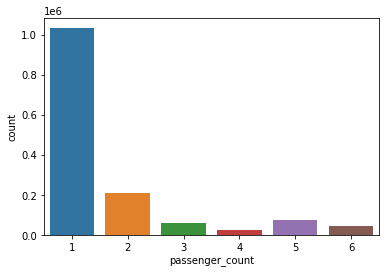

In [ ]:
#plot the count plot of passengers count
sns.countplot(data.passenger_count)
plt.show()

We can see most of trips was taken by single passenger and that is inline with our day to day observations

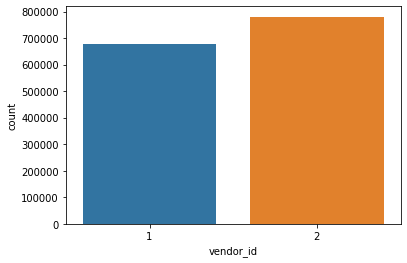

In [ ]:
#plot the count plot for data vendor id
sns.countplot(data.vendor_id)
plt.show()

 Vendor 2 is evidently famous among the population as per the above graph.

<a id='distance'></a>
## Distance


In [ ]:
#Check the statistical summary of the distance
data.distance.describe()

count    1.458639e+06
mean     3.440876e+00
std      4.296547e+00
min      0.000000e+00
25%      1.231841e+00
50%      2.093727e+00
75%      3.875344e+00
max      1.240910e+03
Name: distance, dtype: float64

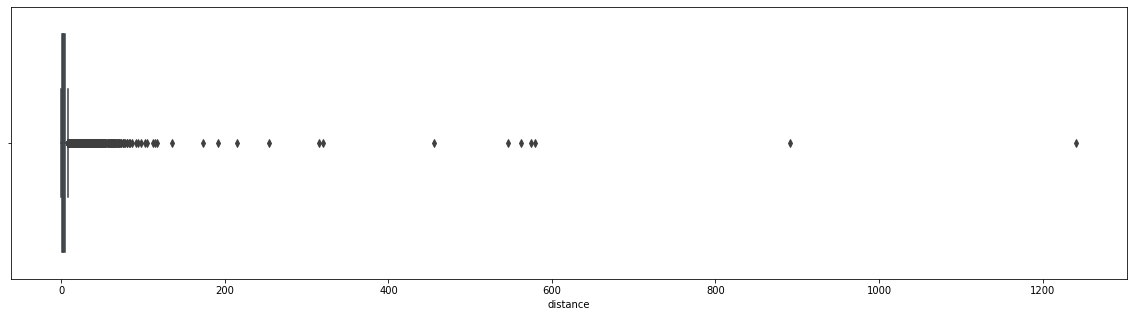

In [ ]:
#plot the box plot for the distance
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()


There are some trips with over 100 km distance and with a distance of 0 km.


In [ ]:
print("There are {} trip with 0 km distance".format(data.distance[data.distance == 0 ].count()))

There are 5895 trip with 0 km distance


In [ ]:
data[data.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,Monday,2,0,18,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,Tuesday,5,1,18,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,Monday,5,0,23,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,Monday,1,0,19,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,Wednesday,1,2,22,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0



- Around 6K trip record with distance equal to 0. 



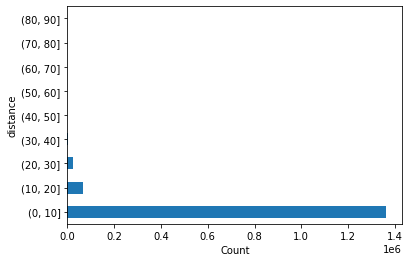

In [ ]:
#plot the horizontal bar plot for the distance
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.xlabel('Count')
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 Kms with some of the rides with distances between 10-30 kms. 

<a id=duration></a>
## Trip duration


In [ ]:
#check the summary of the trip duration
data.trip_duration.describe()

count    1.458639e+06
mean     9.594951e+02
std      5.237440e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

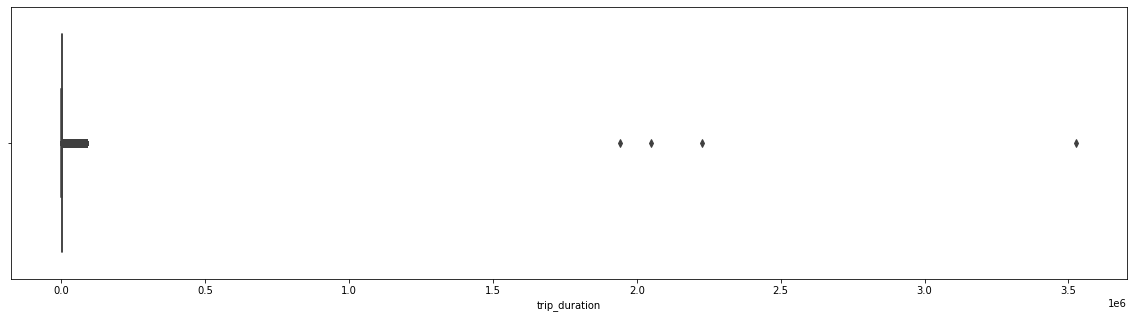

In [ ]:
#plot the boxplot for the trip duration
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

In [ ]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

In [ ]:
#remove the outliers from the data set
data = data[data.trip_duration <= 86400]

Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

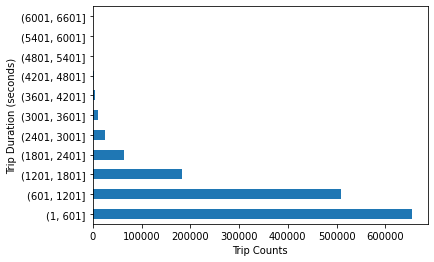

In [ ]:
#plot the horizontal bar plot for the trip duration
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

<a id=speed></a>
## Speed
***
Speed is a function of distance and time. Let's visualize speed in different trips.



In [ ]:
#check the summary of the speed
data.speed.describe()

count    1.458635e+06
mean     1.442318e+01
std      1.497671e+01
min      0.000000e+00
25%      9.121368e+00
50%      1.279202e+01
75%      1.784496e+01
max      9.274850e+03
Name: speed, dtype: float64

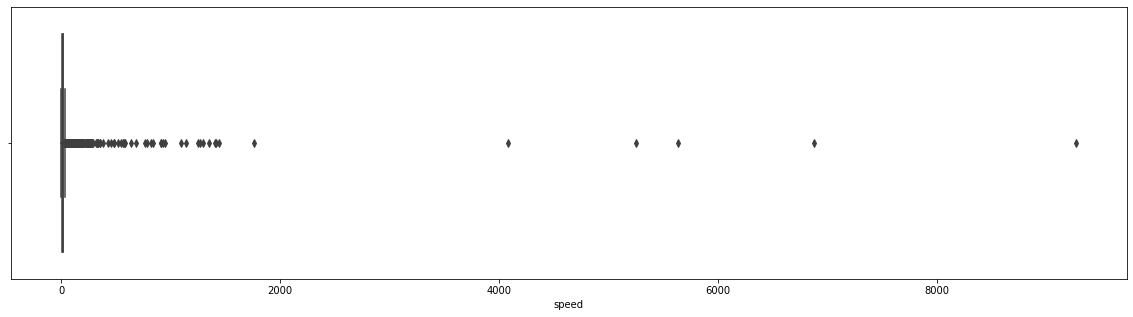

In [ ]:
#plot the boxplot for the speed
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()


- Many trips were done at a speed of over 200 km/h. 

Let's remove them and focus on the trips which were done at less than 104 km/h as per the speed limits

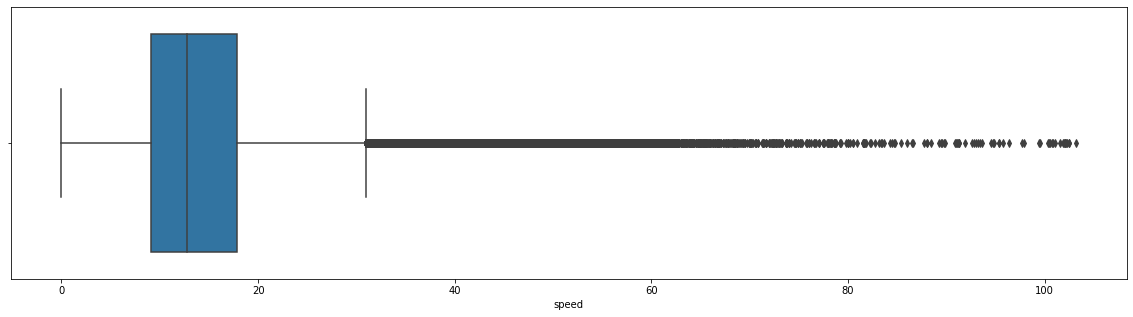

In [ ]:
#remove the outliers and plot the box plot for the speed
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

### Observations:
- Trips over 30 km/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 104 km/h on state controlled highways.
- Mostly trips are done at a speed range of 10-20 km/h with an average speed of around 14 km/h.

Let's take a look at the speed range ditribution with the help of graph.

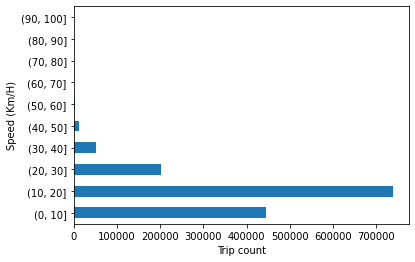

In [ ]:
#plot the bar plot for the speed
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

It is evident from this graph what we thought off earlier i.e. most of the trips were done at a speed range of 10-20 km/H.

<a id=hour_trip></a>
## Total trips Per Hour
***
Let's take a look at the distribution of the pickups across the 24 hour time scale.

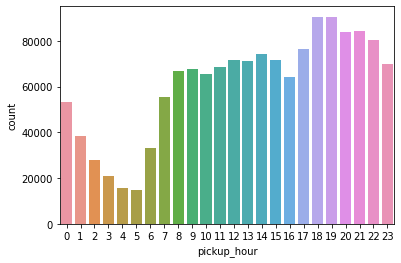

In [ ]:
#plot the count plot for the pickup hours
sns.countplot(data.pickup_hour)
plt.show()

General trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

<a id=week_trip></a>
## Total trips per weekday
***
Let's take a look now at the distribution of taxi pickups across the week.

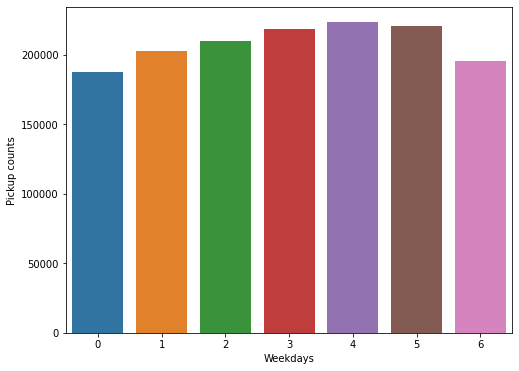

In [ ]:
#plot the pickup count for a week
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel('Weekdays')
plt.ylabel('Pickup counts')
plt.show()

Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday.


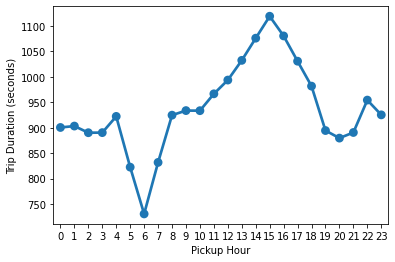

In [ ]:
#plot the line plot for tripduration and pickup hours
pickup = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(pickup.index, pickup.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

Average trip duration is generally highest around 3 PM during the busy streets.


<a id=vendor_duration></a>
## Trip duration per vendor
***
We can also look at the average difference between the trip duration for each vendor. However we do know that vendor 2 has larger share of the market. Let's visualize.

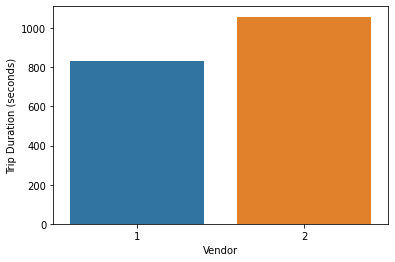

In [ ]:
#plot the bar plot for trip duration and vendor
vendor = data.groupby('vendor_id').trip_duration.mean()
sns.barplot(vendor.index, vendor.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

This is more or less same picture with both the vendors. Nothing more to analyze in this.

In [ ]:
X=data.drop(['pickup_datetime','dropoff_datetime','store_and_fwd_flag','trip_duration','weekday','id'],axis=1)
y=data['trip_duration']

<a id=split></a>
### Split Data
Before training our model on the dataset, we need to split the dataset into training and testing datasets. This is required to train our model on the major part of our dataset and test the accuracy of the model on the minor part. Let's split it

In [ ]:
#spliting the data
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=4, test_size=0.2)

<a id=model></a>
# Model
***
We need a model to train on our dataset to serve our purpose of prediciting the NYC taxi trip duration given the other features as training and test set. Since our dependent variable contains continous values so we will use regression technique to predict our output.

#Linear Regression

In [ ]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test)

In [ ]:
#Evaluate the regressor on the raw data
print('RMSE score of the model is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score of the model is : %.2f' % regressor.score(X_test, y_test))
print("\n")

RMSE score of the model is : 3144.9562748602616
Variance score of the model is : 0.06




<a id=xgboost></a>
## XGBoost Regressor
***
XGBoost (Extreme Gradient Boosting) is an optimized distributed gradient boosting library. It uses gradient boosting (GBM) framework at core. It belongs to a family of boosting algorithms that convert weak learners into strong learners. A weak learner is one which is slightly better than random guessing.

'Boosting' here is a sequential process; i.e., trees are grown using the information from a previously grown tree one after the other. This process slowly learns from data and tries to improve its prediction in the subsequent iterations.

### Model training
***
We will train the model on the filtered features. Our data has already been split so we will not split the data further.

#### Note:
We used **GridSearch** to tune the **hyperparameters** of XGBoost regressor to get the best possible test score.  We will compare results from the default regressor and the tuned regressor.

In [ ]:

#instantiate the object for the XGBoost Regressor with tuned hyper parameters 
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)



In [ ]:
#Train the object with tuned params for Feature Selection Group
regressor_xgb1.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=300,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.75, verbosity=1)

### Model prediction

In [ ]:
#Predict the output with object of default params for raw data
y_pred_xgbraw = regressor_xgb1.predict(X_test)



### Model Evaluation

In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the XGBoost regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgbraw))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor raw is : %.2f' % regressor_xgb1.score(X_test, y_test))


RMSE score for the XGBoost regressor raw is : 256.8112292150012
Variance score for the XGBoost regressor raw is : 0.99


In [ ]:
#Comparing test results for the XGBoost and RF regressor
print("Total sum of difference between the actual and the predicted values for the RF regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_rf))))
print("Total sum of difference between the actual and the predicted values for the tuned XGB regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_xgb1))))

### General inference
- XGBoost proved to be much more efficient in predicting the output. But it takes much more time to train it over the large dataset wih more complexity as compared to the RF and Linear regression model but less time then the SVM

<a id=final></a>
## Conclusion



*    Most of trip consist of passenger either 1 or 2.
*  Average trip duration is generally highest around 3 PM during the busy streets.

*   most of the trips were done at a speed range of 10-20 km/H.

*   Vendor 2 is evidently famous among the population

*   XGBoost proved to be much more efficient in predicting the output. But it takes much more time to train it over the large dataset wih more complexity as compared to the RF and Linear regression model but less time then the SVR.

*   List item






